In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
import datetime

In [51]:
# cstdata = pd.read_csv('Data/DT_Performix_Customer_Data.csv')
# orddata = pd.read_csv('Data/Performix_order_level_data.csv')


cstdata = pd.read_csv('Data/customer_data_updated.csv')
orddata = pd.read_csv('Data/order_data_10aug.csv')


In [52]:
os.makedirs('Plots',exist_ok=True)

In [53]:
date_of_analysis = cstdata['first_order_date'].max()

In [54]:
## EXTRA FUNCTIONS
def print_fulldf(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(df)

### PLOT PARAMS

In [55]:
figsize = (18,6)
axisfont = 14
titlefont = 16
ticksize = 12

color3 = ['mediumseagreen','steelblue','darkorange']
color2 = ['steelblue','darkorange']

updated_at = cstdata['first_order_date'].max()


from collections import OrderedDict
cmaps = OrderedDict()



### A - Count of Acquisitions by Customer 

In [56]:
a = cstdata.copy()
a['first_order_date'] = pd.to_datetime(a['first_order_date'],format = '%Y-%m-%d')
a['Month'] = a['first_order_date'].dt.month
a['Year'] = a['first_order_date'].dt.year
a = pd.DataFrame({'Acquisitions':a.groupby(['Year','Month']).size()})
#a = a.iloc[:-1,:]
a = a.iloc[-25:,:]

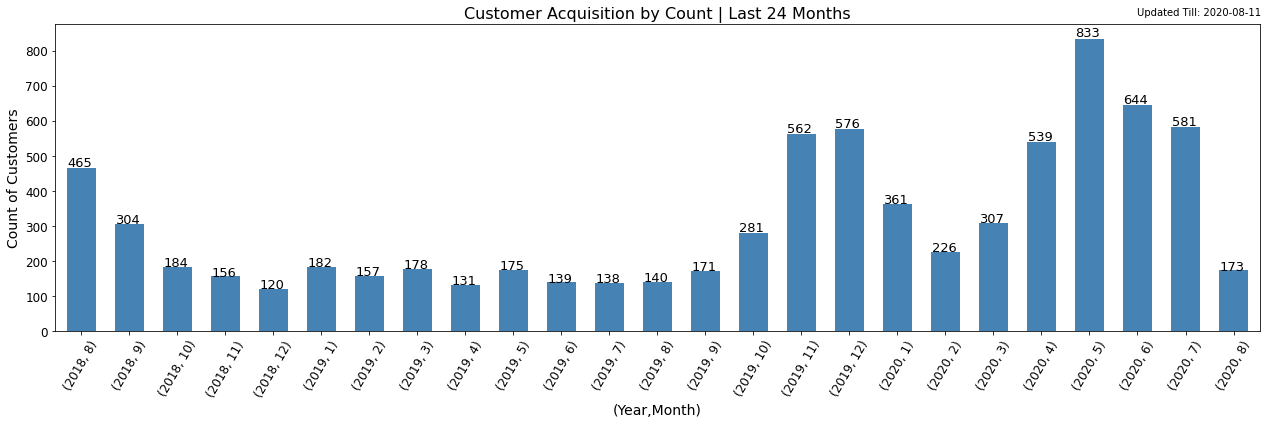

In [57]:
fig,ax = plt.subplots(figsize = figsize)
a.plot.bar(ax = ax,width = 0.6,color = color2[0])
ax.set_xlabel('(Year,Month)',fontsize = axisfont)
ax.set_ylabel('Count of Customers',fontsize = axisfont)
ax.set_title('Customer Acquisition by Count | Last 24 Months',fontsize = titlefont)
ax.text(21.99,900,"Updated Till: {f}".format(f=cstdata['first_order_date'].max()))
plt.xticks(fontsize=ticksize, rotation=60)
plt.yticks(fontsize=ticksize)
for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x() + 0.00905, p.get_height() * 1.01),fontsize = 13)
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('Plots/A_Cx_Acquisition.jpg')

### B - Count & Type of Customers by Month

In [58]:
b = orddata.copy()
b['order_date'] = pd.to_datetime(b['order_date'] ,format = '%Y-%m-%d')
b['order_date_datetime'] = pd.to_datetime(b['order_date_datetime'] ,format = '%Y-%m-%d %H:%M:%S')
b['Month'] = b['order_date_datetime'].dt.month
b['Year'] = b['order_date_datetime'].dt.year

total_unique_customers = b.groupby(['Year','Month']).agg({'customer_id':'nunique'})
total_unique_customers.rename(columns={'customer_id':'Total Customers'},inplace = True)


customer_history = pd.DataFrame(b.groupby(['customer_id'])['order_date_datetime'].min())
customer_history.columns = ['customer_first_order']
order_data = pd.merge(b,customer_history.reset_index(),on='customer_id',how = 'left')
order_data['order_type'] = np.where(order_data['order_date_datetime']==order_data['customer_first_order'], 'New', 'Repeat')
order_data.sort_values(['order_date'],inplace = True)
order_data.reset_index(drop = True,inplace = True)

In [59]:
order_data = order_data.sort_values(['order_date_datetime','order_type'],ascending = True)
order_data = order_data.groupby(['customer_id','Month','Year']).head(1)

In [60]:
# 1. 
b_data = order_data.groupby(['Year','Month','order_type']).agg({'customer_id':'nunique'}).unstack(2).droplevel(axis = 1,level = 0)
#b_data = b_data.iloc[:-1,:]
b_data = b_data.iloc[-25:,:]
b_data = b_data[['Repeat','New']]
b_data['Percentage New'] = round(b_data['New']/b_data.sum(1)*100,2)

In [61]:
totals_b = b_data.drop('Percentage New',1).sum(1)

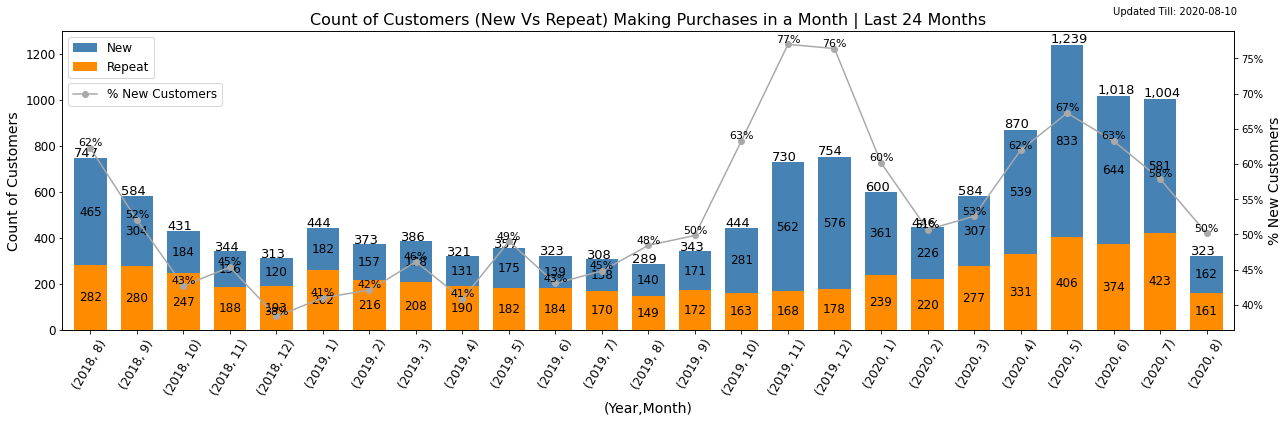

In [62]:
rev_color2 = color2.copy()
rev_color2.reverse()
fig,ax = plt.subplots(figsize = figsize)
b_data.drop('Percentage New',1).plot.bar(ax = ax,stacked = True,width = 0.7,color = rev_color2)
ax.set_xlabel('(Year,Month)',fontsize = axisfont)
ax.set_ylabel('Count of Customers',fontsize = axisfont)
ax.set_title('Count of Customers (New Vs Repeat) Making Purchases in a Month | Last 24 Months',fontsize = titlefont)
plt.xticks(fontsize=12, rotation=60)
plt.xticks(fontsize=ticksize, rotation=60)
plt.yticks(fontsize=ticksize)


ind = range(0,len(totals_b.index))
for i,v in enumerate(totals_b):
    ax.annotate(format(int(v),','),(ind[i]-0.35,totals_b[i]*1.009),fontsize = 13,fontweight = 'medium')
    

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',fontsize = 12)

ax.text(21.99,1370,"Updated Till: {f}".format(f=orddata['order_date'].max()))
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

ax2 = ax.twinx()
b_data['Percentage New'].plot(ax=ax2,marker = 'o',color='darkgray')#color='coral',
ax2.set_ylabel('% New Customers',fontsize = axisfont)

perc_labels = True
if perc_labels:
    x = range(0,len(b_data.index))
    for i, txt in enumerate(b_data['Percentage New'].values):
        ax2.annotate(str(round(txt))+'%', (x[i], b_data['Percentage New'].values[i]), ha='center',va = 'bottom',fontsize =11,color = 'black') 


from matplotlib.ticker import FuncFormatter,PercentFormatter
ax2.yaxis.set_major_formatter(PercentFormatter(decimals = 0))

#ax.legend( title='Line', loc='upper left')    
ax.legend(handles[::-1], labels[::-1],loc=2,prop={'size':12})
ax2.legend(['% New Customers'],loc = (0.005,0.75),fontsize = 12)

#plt.grid(linestyle = '--',axis = 'y',color = 'lightgrey')
plt.tight_layout()
plt.savefig('Plots/B_1_First_Repeat_Count_CX.jpg')

###  REPEAT RATE

### ORDER TYPE REV

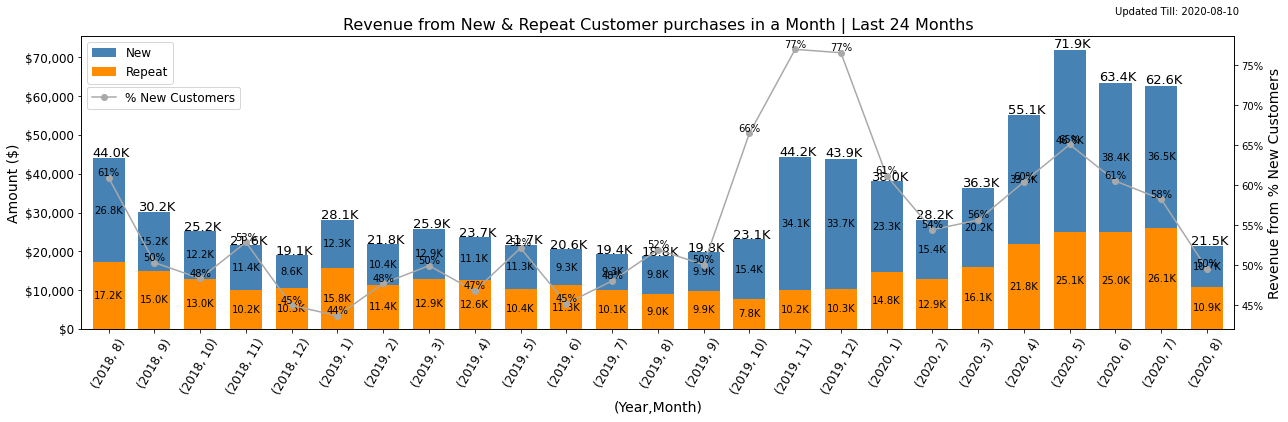

In [63]:
# 1. 
b_data = order_data.groupby(['Year','Month','order_type']).agg({'amount':'sum'}).unstack(2).droplevel(axis = 1,level = 0)
#b_data = b_data.iloc[:-1,:]
b_data = b_data.iloc[-25:,:]
b_data = b_data[['Repeat','New']]

b_data['Percentage New'] = round(b_data['New']/b_data.sum(1)*100,2)
b_data.columns.name = None

totals_b = b_data.drop('Percentage New',1).sum(1)


fig,ax = plt.subplots(figsize = figsize)
b_data.drop('Percentage New',1).plot.bar(ax = ax,stacked = True,width = 0.7,color = rev_color2)

ax.set_xlabel('(Year,Month)',fontsize = axisfont)
ax.set_ylabel('Amount ($)',fontsize = axisfont)
ax.set_title('Revenue from New & Repeat Customer purchases in a Month | Last 24 Months',fontsize = titlefont)
plt.xticks(fontsize=12, rotation=60)
plt.xticks(fontsize=ticksize, rotation=60)
plt.yticks(fontsize=ticksize)


millnames = ['','K',' M',' B',' T']
import math
def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:.1f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

ind = range(0,len(totals_b.index))
for i,v in enumerate(totals_b):
    s = millify(v)
    ax.annotate(s,(ind[i]-0.35,totals_b[i]*1.009),fontsize = 13,fontweight = 'medium')



for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
#            '{:.0f}'.format(height), 
            millify(height),
            horizontalalignment='center', 
            verticalalignment='center',fontsize = 10)
from matplotlib.ticker import StrMethodFormatter
fmt = '${x:,.0f}'
tick = StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

ax.text(21.99,81000,"Updated Till: {f}".format(f=orddata['order_date'].max()))

#ax.legend( title='Line', loc='upper left')   


ax2 = ax.twinx()
b_data['Percentage New'].plot(ax=ax2,marker = 'o',color='darkgray')#color='coral',
ax2.set_ylabel('Revenue from % New Customers',fontsize = axisfont)

perc_labels = True
if perc_labels:
    x = range(0,len(b_data.index))
    for i, txt in enumerate(b_data['Percentage New'].values):
        ax2.annotate(str(round(txt))+'%', (x[i], b_data['Percentage New'].values[i]), ha='center',va = 'bottom',fontsize =10,color = 'black') 
from matplotlib.ticker import FuncFormatter,PercentFormatter
ax2.yaxis.set_major_formatter(PercentFormatter(decimals = 0))

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[::-1], labels[::-1],loc=2,prop={'size':12})
ax2.legend(['% New Customers'],loc = (0.005,0.75),fontsize = 12)


#plt.legend(handles[::-1], labels[::-1],loc=2,prop={'size':12})
plt.tight_layout()
plt.savefig('Plots/B_2_First_Repeat_REV.jpg')

### CUSTOMER TYPE AOV

In [64]:
foo = order_data.groupby(['Year','Month','order_type']).agg({'amount':'sum','order_id':'count'})
foo['AOV'] = foo['amount']/foo['order_id']
foo = foo.drop(['amount','order_id'],1)
foo = foo.unstack(2)
foo = foo.droplevel(axis = 1,level = 0)

foo.index.name = None
foo = foo.iloc[-25:,:]

/home/rijumone/Kitchen/python/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


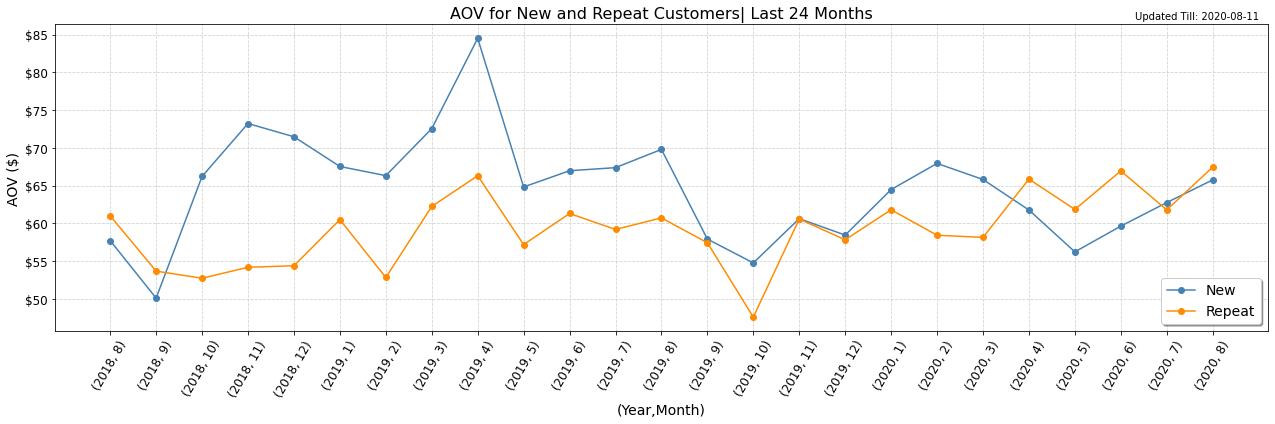

In [65]:
fig,ax = plt.subplots(figsize = figsize)
foo.plot(ax = ax,color = color2,marker = 'o')

# plt.axhline(foo.mean()['New'], color='tab:green',label = '30 Days AVG LTV',linestyle = 'dashed')
# plt.axhline(foo.mean()['Repeat'], color='tab:blue',label = '60 Days AVG LTV',linestyle = 'dashed')


ax.set_xlabel('(Year,Month)',fontsize = axisfont)
ax.set_ylabel('AOV ($)',fontsize = axisfont)
ax.set_title('AOV for New and Repeat Customers| Last 24 Months',fontsize = titlefont)
plt.xticks(fontsize=ticksize, rotation=60)
plt.yticks(fontsize=ticksize)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',fontsize = 10,color = 'white')

plt.grid(linestyle = '--',color= 'lightgrey')
plt.xticks(range(0,len(foo.index)), foo.index)

ax.text(22.3,87,"Updated Till: {f}".format(f=updated_at))
from matplotlib.ticker import StrMethodFormatter
fmt = '${x:,.0f}'
tick = StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=3, fancybox=True, shadow=True,fontsize = 12)
ax.legend(loc=4,# bbox_to_anchor=(0.5, 1),
          ncol=1, fancybox=True, shadow=True,fontsize = 12,prop = {'size':14})


#plt.legend(prop={'size':12})
plt.tight_layout()
plt.savefig('Plots/R_AOV_Type.jpg')

## TOTAL VS NEW COUNT

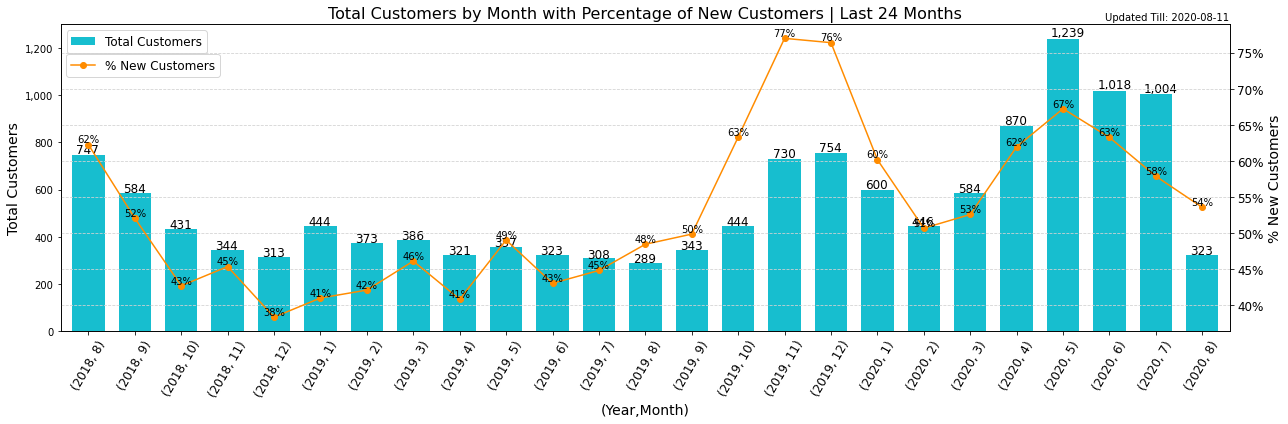

In [66]:
b_data_dual = pd.merge(left = a,right = total_unique_customers,left_index=True,right_index=True)
b_data_dual['Percentage New'] = round((b_data_dual['Acquisitions']/b_data_dual['Total Customers'])*100,2)
b_data_dual = b_data_dual.drop(['Acquisitions'],1)



## PLOT
fig,ax = plt.subplots(figsize=figsize) 

perc_labels = True
width = 0.7
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.


b_data_dual['Total Customers'].plot(kind='bar', ax=ax, width=0.7, color= 'tab:cyan')#color='tab:cyan'
b_data_dual['Percentage New'].plot( ax=ax2,marker = 'o',color=color2[1])#color='coral',

ax.set_xlabel("(Year,Month)",fontsize = axisfont)
ax.set_ylabel('Total Customers',fontsize = axisfont)
ax2.set_ylabel('% New Customers',fontsize = axisfont)


plt.xticks(fontsize=ticksize, rotation=60)
plt.yticks(fontsize=ticksize)

if perc_labels:
    x = range(0,len(b_data_dual.index))
    for i, txt in enumerate(b_data_dual['Percentage New'].values):
        ax2.annotate(str(round(txt))+'%', (x[i], b_data_dual['Percentage New'].values[i]), ha='center',va = 'bottom',fontsize =10,color = 'black') 


for p in ax.patches:
        ax.annotate(str(format(int(p.get_height()),',')), (p.get_x() + 0.0905, p.get_height() * 1.01),fontsize = 12)


plt.grid(linestyle = '--',color = 'lightgrey')
ax.set_xticklabels(labels = b_data_dual.index,rotation=60 ,fontsize = ticksize)

ax.text(21.9,1320,"Updated Till: {f}".format(f=updated_at))

ax.legend(['Total Customers'],loc = 2,fontsize = 12)
ax2.legend(['% New Customers'],loc = (0.005,0.83),fontsize = 12)

from matplotlib.ticker import FuncFormatter,PercentFormatter
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.yaxis.set_major_formatter(PercentFormatter(decimals = 0))


plt.title("Total Customers by Month with Percentage of New Customers | Last 24 Months",fontsize = titlefont)
plt.tight_layout()
plt.savefig('Plots/B_2_TotalCX_PercNew.jpg')

### C - Total Revenue by Month with % revenue from New

In [67]:
c_data = order_data.groupby(['Year','Month','order_type']).agg({'amount':sum}).unstack(2).droplevel(axis = 1 , level = 0)
c_data.columns.name = None
c_data['Total Revenue'] = c_data.sum(1)
c_data['Percentage New'] = round((c_data['New']/c_data['Total Revenue'])*100,2)
c_data.drop(['Repeat','New'],1,inplace = True)
#c_data = c_data.iloc[:-1,:]
c_data = c_data.iloc[-25:,:]

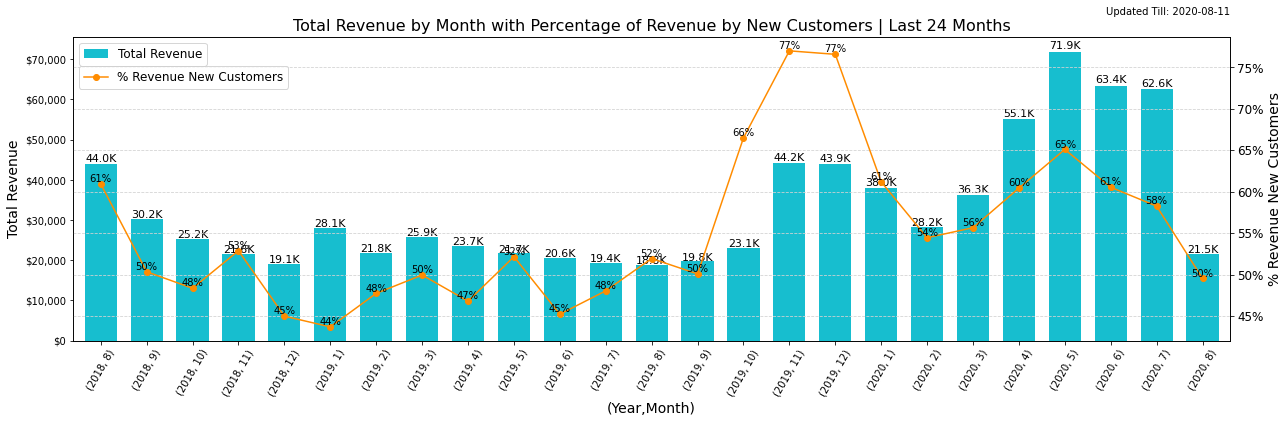

In [68]:
fig,ax = plt.subplots(figsize=figsize) 
perc_labels = True

ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.7

c_data['Total Revenue'].plot(kind='bar', color='tab:cyan', ax=ax, width=0.7)
c_data['Percentage New'].plot(color=color2[1], ax=ax2,marker = 'o')

ax.set_xlabel("(Year,Month)",fontsize = axisfont)
ax.set_ylabel('Total Revenue',fontsize = axisfont)
ax2.set_ylabel('% Revenue New Customers',fontsize = axisfont)


plt.xticks(fontsize=ticksize, rotation=60)
plt.yticks(fontsize=ticksize)

import math

millnames = ['','K',' M',' B',' T']
def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:.1f}{}'.format(n / 10**(3 * millidx), millnames[millidx])
for p in ax.patches:
    v = int(p.get_height())
    v = millify(v)
    ax.annotate(v, (p.get_x() + 0.00905, p.get_height() * 1.01),fontsize = 11)

if perc_labels:
    x = range(0,len(c_data.index))
    for i, txt in enumerate(c_data['Percentage New'].values):
        ax2.annotate(str(round(txt))+'%', (x[i], c_data['Percentage New'].values[i]), ha='center',va = 'bottom',fontsize =10,color = 'black') 

ax.text(21.9,81000,"Updated Till: {f}".format(f=updated_at))
plt.grid(linestyle = '--',color = 'lightgrey')
ax.set_xticklabels(labels = c_data.index,rotation=60 ,fontsize = 10)


ax.legend(['Total Revenue'],loc = 2,fontsize = 12)
ax2.legend(['% Revenue New Customers'],loc = (0.005,0.83),fontsize = 12)

from matplotlib.ticker import FuncFormatter,PercentFormatter
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.yaxis.set_major_formatter(PercentFormatter(decimals = 0))

from matplotlib.ticker import StrMethodFormatter
fmt = '${x:,.0f}'
tick = StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.title("Total Revenue by Month with Percentage of Revenue by New Customers | Last 24 Months",fontsize = titlefont)
plt.tight_layout()
plt.savefig('Plots/C_TotalREV_NewCX_Rev.jpg')

#### E - Frequency of Orders by Customers Till April 2020

In [69]:
e = cstdata.copy()
e['first_order_date'] = pd.to_datetime(e['first_order_date'],format = '%Y-%m-%d')
e = e[e['first_order_date']<'2020-05-01']
e = e.groupby(['no_of_orders']).agg({'customer_id':'nunique'}).rename(columns = {'customer_id':'No of Customers'})
e.index.name = "No of Orders"

# foo = e.div(e.sum())*100
# foo = foo.cumsum()
# e['Percentage Cumulation'] = foo.values

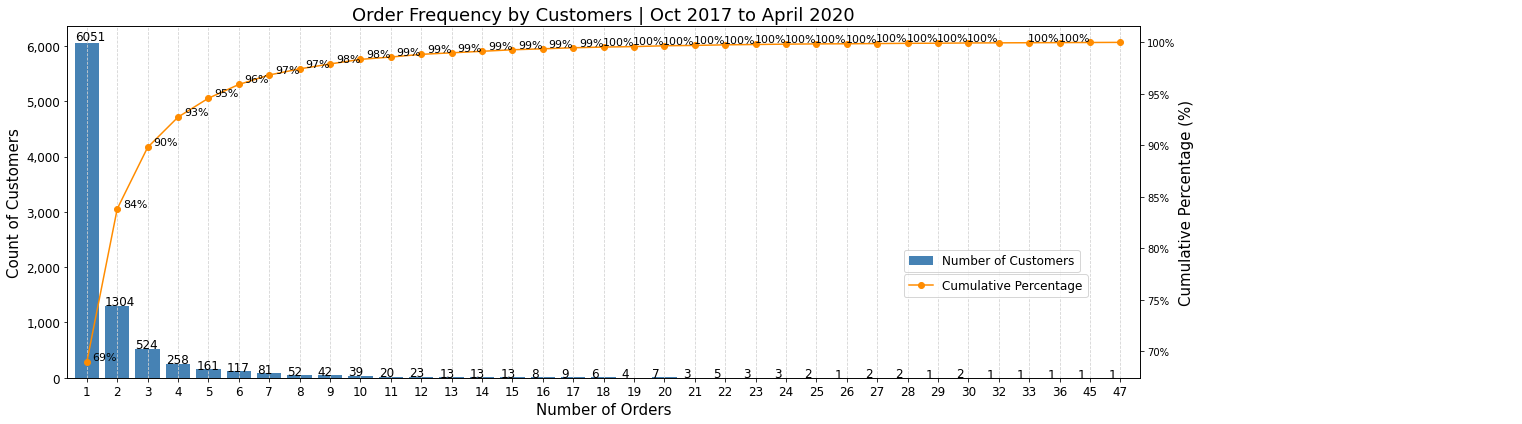

In [70]:
fig,ax = plt.subplots(figsize = (22,6))
e.plot.bar(ax = ax,width = 0.8,color = color2[0],label = 'Number of Customers')
ax.set_xlabel('Number of Orders',fontsize = axisfont+1)
ax.set_ylabel('Count of Customers',fontsize = axisfont+1)
ax.set_title('Order Frequency by Customers | Oct 2017 to April 2020',fontsize = titlefont+2)
plt.xticks(fontsize=ticksize, rotation=0)
plt.yticks(fontsize=ticksize)
for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x() + 0.000905, p.get_height() * 1.01),fontsize = 12)
ax.get_legend().remove()

ax2 = ax.twinx()
hum = (e.div(e.sum()).cumsum()*100).rename(columns = {'No of Customers':'Cumulative Percentage'})
ax2.plot(hum.values,color = color2[1],marker = 'o',label = 'Cumulative Percentage')
ax2.set_ylabel('Cumulative Percentage (%)',fontsize = axisfont+1)


for i, txt in enumerate(hum['Cumulative Percentage'].values):
    ax2.annotate(str(round(txt))+'%', (hum.index[i], hum['Cumulative Percentage'].values[i]), ha='right',va = 'bottom',fontsize =11) 

#ax.text(29.5,8500,"Updated Till: {f}".format(f=updated_at))

ax.legend(['Number of Customers'],loc = (0.78,0.3),fontsize = 12)
ax2.legend(['Cumulative Percentage'],loc = (0.78,0.23),fontsize = 12)
ax.xaxis.grid(linestyle = '--',color = 'lightgrey')

from matplotlib.ticker import FuncFormatter,PercentFormatter
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.yaxis.set_major_formatter(PercentFormatter(decimals = 0))


plt.tight_layout()
plt.savefig('Plots/E_CX_Repeat_Purchase.jpg')

### F - Lifetime Distribution Monthly

In [71]:
perc_values = True

f = cstdata.copy()
f['first_order_date'] = pd.to_datetime(f['first_order_date'],format = '%Y-%m-%d')
f['last_order_day'] = pd.to_datetime(f['last_order_day'],format = '%Y-%m-%d')

f['Month'] = f['first_order_date'].dt.month
f['Year'] = f['first_order_date'].dt.year


f['cxlife'] = (f['last_order_day'] - f['first_order_date']).dt.days
bins = [0,0.5,90,180,270,360,np.inf]
names = ['0','0-3 M','3-6 M','6-9 M', '9-12 M','12+ M']

f['cxlife_range'] = pd.cut(f['cxlife'], bins, labels=names)
f['cxlife_range'] = f['cxlife_range'].fillna('0')

f_data = f.groupby(['Year','Month','cxlife_range']).size().unstack(2)
f_data.columns.name = None
f_data = f_data.iloc[:-4,:]
f_data = f_data.iloc[-25:,:]


if perc_values:
    f_data = f_data.div(f_data.sum(1),0)*100
    f_data = f_data.round(2)

In [72]:
cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']

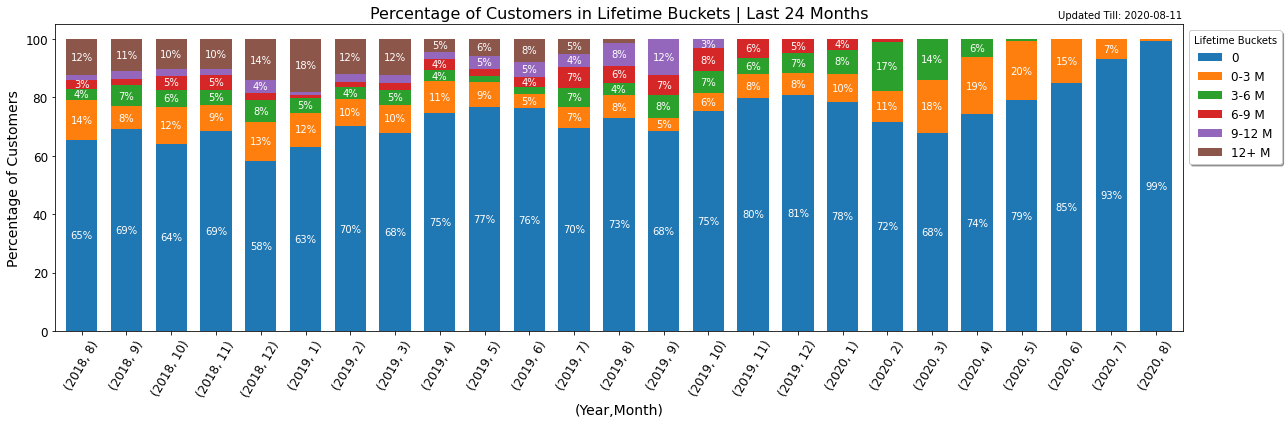

In [73]:
fig,ax = plt.subplots(figsize = figsize)
f_data.plot.bar(ax = ax,stacked = True,width = 0.7)
ax.set_xlabel('(Year,Month)',fontsize = axisfont)
ax.set_ylabel('Percentage of Customers',fontsize = axisfont)
ax.set_title('Percentage of Customers in Lifetime Buckets | Last 24 Months',fontsize = titlefont)
plt.xticks(fontsize=ticksize, rotation=60)
plt.yticks(fontsize=ticksize)

if perc_values:
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if height >3:
            ax.text(x+width/2, 
                    y+height/2, 
                    '{:.0f}%'.format(height), 
                    horizontalalignment='center', 
                    verticalalignment='center',fontsize = 10,color = 'white')
  
    
from matplotlib.ticker import FuncFormatter,PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(decimals = 0))
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))


plt.legend(loc=2,prop={'size':14},title = 'Lifetime Bucket',fancybox = True)
#plt.grid(linestyle = '--',color= 'lightgrey',axis = 'y')
ax.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize = 12,title = 'Lifetime Buckets',fancybox=True, shadow=True)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1),
#          ncol=3, fancybox=True, shadow=True,fontsize = 12,title = 'Lifetime Buckets')
ax.text(21.8,107,"Updated Till: {f}".format(f=updated_at))
plt.tight_layout()
plt.savefig('Plots/F_LifetimeBuckets_Distr.jpg')

### D - 30,60,90 Days LTV

In [74]:
d = cstdata.copy()
d['Today'] = date_of_analysis
d['Today'] = pd.to_datetime(d['Today'],format = '%Y-%m-%d')
d['first_order_date'] = pd.to_datetime(d['first_order_date'],format = '%Y-%m-%d')
d['last_order_day'] = pd.to_datetime(d['last_order_day'],format = '%Y-%m-%d')

d['Month'] = d['first_order_date'].dt.month
d['Year'] = d['first_order_date'].dt.year



d['cxlife'] = (d['Today'] - d['first_order_date']).dt.days

ind = []
ltvs = []

for l in [30,60,90]:
    d1 = d.copy()
    d1 = d1[d1['cxlife']>=l]
    d1ltv = d1.groupby(['Year','Month']).agg({'"{l}_days_sum_of_rev"'.format(l=l):sum,'customer_id':'size'})
    d1ltv.columns = ['{l}_days_sum_of_rev'.format(l=l),'count_of_custs']
    d1ltv['{l}_Days_LTV'.format(l=l)] = d1ltv['{l}_days_sum_of_rev'.format(l=l)]/d1ltv['count_of_custs']
    ltvs.append(d1ltv['{l}_Days_LTV'.format(l=l)])

ltv = pd.concat(ltvs,1)
#ltv = ltv.iloc[:-3]
ltv = ltv.iloc[-25:,]

In [75]:
ltv.mean()['30_Days_LTV']
ltv.mean()['60_Days_LTV']
ltv.mean()['90_Days_LTV']

83.74757914077472

In [76]:
ltv.iloc[-1,0] = None
ltv.iloc[-2,1] = None
ltv.iloc[-3,2] = None

In [77]:
ltv.head()

30_Days_LTV  60_Days_LTV  90_Days_LTV
Year Month                                       
2018 7        74.566389    84.976871    94.595295
     8        66.687032    73.732688    78.670301
     9        55.700132    59.037500    64.950197
     10       75.962500    80.280435    85.019511
     11       77.181218    82.997372    88.704551

/home/rijumone/Kitchen/python/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


'\nax.text(21,103,"Updated Till: {f}".format(f=date_of_analysis))\nfrom matplotlib.ticker import StrMethodFormatter\nfmt = \'${x:,.0f}\'\ntick = StrMethodFormatter(fmt)\nax.yaxis.set_major_formatter(tick) \n\n# ax.legend(loc=\'upper center\', bbox_to_anchor=(0.5, 1),\n#           ncol=3, fancybox=True, shadow=True,fontsize = 12)\n#plt.legend(prop={\'size\':12})\nax.legend(loc="upper left", bbox_to_anchor=(1,0.8),fontsize = 12,title = \'Legend:\',fancybox=True, shadow=True,prop = {\'size\':14})\nplt.tight_layout()\nplt.savefig(\'Plots/D_LTV_AcqMonth.jpg\')'

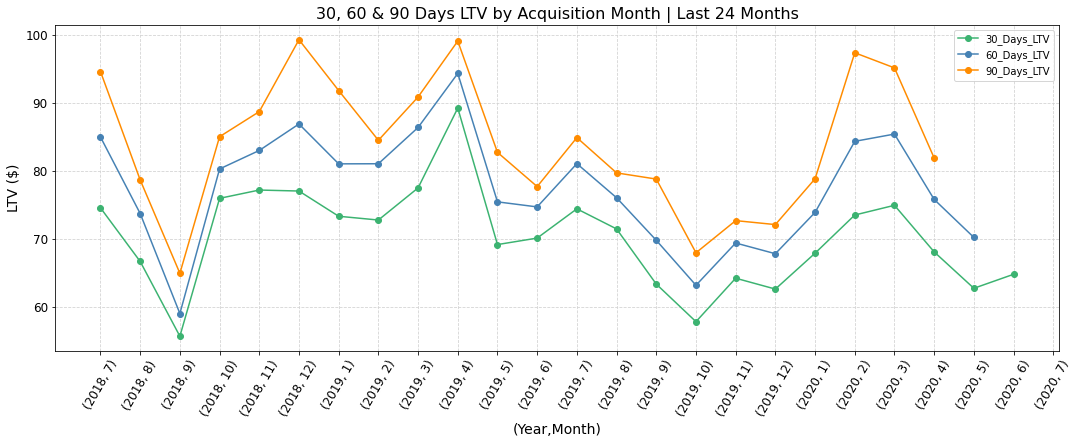

In [78]:
fig,ax = plt.subplots(figsize = figsize)
ltv.plot(ax = ax,color = color3,marker = 'o')
'''
plt.axhline(ltv.mean()['30_Days_LTV'], color='tab:green',label = '30 Days AVG LTV',linestyle = 'dashed')
plt.axhline(ltv.mean()['60_Days_LTV'], color='tab:blue',label = '60 Days AVG LTV',linestyle = 'dashed')
plt.axhline(ltv.mean()['90_Days_LTV'], color='tab:orange',label = '90 Days AVG LTV',linestyle = 'dashed')
'''
ax.set_xlabel('(Year,Month)',fontsize = axisfont)
ax.set_ylabel('LTV ($)',fontsize = axisfont)
ax.set_title('30, 60 & 90 Days LTV by Acquisition Month | Last 24 Months',fontsize = titlefont)
plt.xticks(fontsize=ticksize, rotation=60)
plt.yticks(fontsize=ticksize)

for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x() + 0.00905, p.get_height() * 1.01),fontsize = 13)
plt.grid(linestyle = '--',color= 'lightgrey')
plt.xticks(range(0,len(ltv.index)), ltv.index)
'''
ax.text(21,103,"Updated Till: {f}".format(f=date_of_analysis))
from matplotlib.ticker import StrMethodFormatter
fmt = '${x:,.0f}'
tick = StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1),
#           ncol=3, fancybox=True, shadow=True,fontsize = 12)
#plt.legend(prop={'size':12})
ax.legend(loc="upper left", bbox_to_anchor=(1,0.8),fontsize = 12,title = 'Legend:',fancybox=True, shadow=True,prop = {'size':14})
plt.tight_layout()
plt.savefig('Plots/D_LTV_AcqMonth.jpg')'''

In [79]:
##new block
d = cstdata.copy()
d['Today'] = date_of_analysis
d['Today'] = pd.to_datetime(d['Today'],format = '%Y-%m-%d')
d['first_order_date'] = pd.to_datetime(d['first_order_date'],format = '%Y-%m-%d')
d['last_order_day'] = pd.to_datetime(d['last_order_day'],format = '%Y-%m-%d')

d['Month'] = d['first_order_date'].dt.month
d['Year'] = d['first_order_date'].dt.year



d['cxlife'] = (d['Today'] - d['first_order_date']).dt.days

ind = []
ltvs = []
a = cstdata.copy()
a['first_order_date'] = pd.to_datetime(a['first_order_date'],format = '%Y-%m-%d')
a['Month'] = a['first_order_date'].dt.month
a['Year'] = a['first_order_date'].dt.year
a = pd.DataFrame({'Acquisitions':a.groupby(['Year','Month']).size()})

for l in [30,60,90]:
    d1 = d.copy()
    d1 = d1[d1['cxlife']>=l]
    d1 = d1[d1['"{l}_days_count_of_orders"'.format(l=l)]>1]
    d1ltv = d1.groupby(['Year','Month']).agg({'customer_id':'size'})
    d1ltv.columns = ['count_of_custs']
    d1ltv1=pd.merge(d1ltv,a,on=['Year','Month'],how='left')
    #order_data = pd.merge(b,customer_history.reset_index(),on='customer_id',how = 'left')
    d1ltv1['{l}_Days_Retention'.format(l=l)] = (d1ltv1['count_of_custs']/d1ltv1['Acquisitions'])*100
    ltvs.append(d1ltv1['{l}_Days_Retention'.format(l=l)])

ltv = pd.concat(ltvs,1)
#ltv = ltv.iloc[:-3]
ltv = ltv.iloc[-25:,]

In [80]:
ltv.iloc[-1,0] = None
ltv.iloc[-2,1] = None
ltv.iloc[-3,2] = None

In [81]:
ltv

30_Days_Retention  60_Days_Retention  90_Days_Retention
Year Month                                                         
2018 7              19.037199          29.759300          33.479212
     8              14.838710          21.290323          25.161290
     9              15.131579          20.065789          23.355263
     10             11.413043          19.565217          25.543478
     11              7.692308          13.461538          17.307692
     12             10.000000          23.333333          30.000000
2019 1               7.692308          17.582418          21.978022
     2              12.101911          21.019108          22.292994
     3               8.426966          16.853933          20.224719
     4               5.343511          12.977099          17.557252
     5               7.428571          12.571429          16.000000
     6               5.035971           9.352518          11.510791
     7               9.420290          17.391304          18.840580
     8               3.571429          11.428571          12.857143
     9               8.771930          16.959064          22.222222
     10              4.270463          11.032028          14.234875
     11              5.160142          10.676157          12.633452
     12              5.555556          10.763889          15.104167
2020 1               7.202216          13.019391          16.620499
     2               7.964602          17.699115          24.336283
     3              12.377850          22.801303          28.338762
     4              10.946197          19.851577          24.489796
     5              10.564226          18.007203                NaN
     6               8.695652                NaN                NaN
     7                    NaN                NaN                NaN

/home/rijumone/Kitchen/python/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


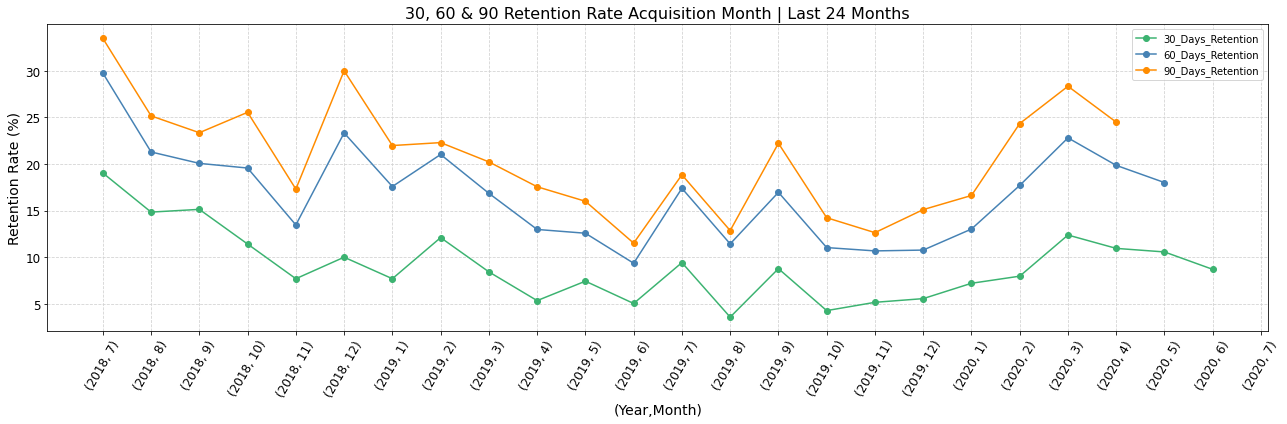

In [82]:
fig,ax = plt.subplots(figsize = figsize)
ltv.plot(ax = ax,color = color3,marker = 'o')
'''
#plt.axhline(ltv.mean()['30_Days_LTV'], color='tab:green',label = '30 Days AVG LTV',linestyle = 'dashed')
#plt.axhline(ltv.mean()['60_Days_LTV'], color='tab:blue',label = '60 Days AVG LTV',linestyle = 'dashed')
#plt.axhline(ltv.mean()['90_Days_LTV'], color='tab:orange',label = '90 Days AVG LTV',linestyle = 'dashed')
'''
ax.set_xlabel('(Year,Month)',fontsize = axisfont)
ax.set_ylabel('Retention Rate (%)',fontsize = axisfont)
ax.set_title('30, 60 & 90 Retention Rate Acquisition Month | Last 24 Months',fontsize = titlefont)
plt.xticks(fontsize=ticksize, rotation=60)
plt.yticks(fontsize=ticksize)

for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x() + 0.00905, p.get_height() * 1.01),fontsize = 13)
plt.grid(linestyle = '--',color= 'lightgrey')
plt.xticks(range(0,len(ltv.index)), ltv.index)
'''
ax.text(21,103,"Updated Till: {f}".format(f=date_of_analysis))
from matplotlib.ticker import StrMethodFormatter
fmt = '${x:,.0f}'
tick = StrMethodFormatter(fmt)'
ax.yaxis.set_major_formatter(tick) 
'''
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1),
#           ncol=3, fancybox=True, shadow=True,fontsize = 12)
#plt.legend(prop={'size':12})
#ax.legend(loc="upper left", bbox_to_anchor=(1,0.8),fontsize = 12,title = 'Legend:',fancybox=True, shadow=True,prop = {'size':14})
plt.tight_layout()
plt.savefig('Plots/new.jpg')


### G - Product Cohorts

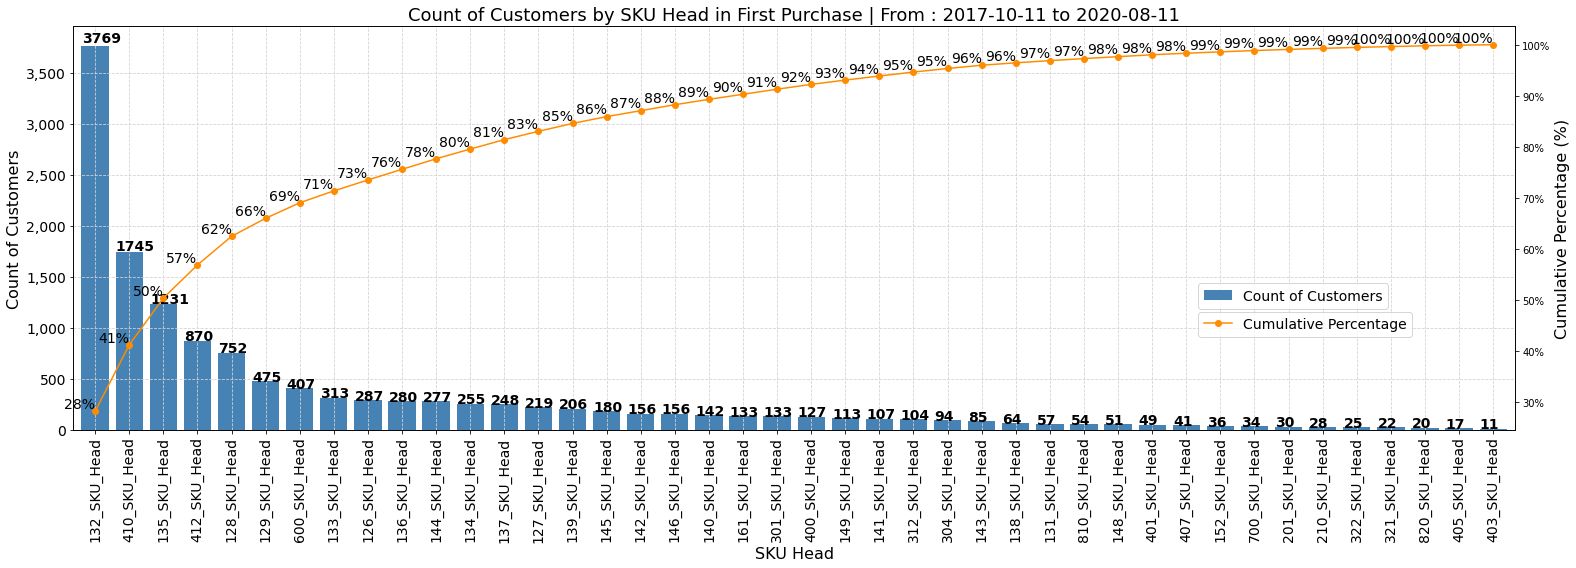

In [83]:
g = cstdata.copy()

g['first_order_date'] = pd.to_datetime(g['first_order_date'],format = '%Y-%m-%d')
g['last_order_day'] = pd.to_datetime(g['last_order_day'],format = '%Y-%m-%d')

#g = g[g['first_order_date']<= '2020-07-31']

g['Month'] = g['first_order_date'].dt.month
g['Year'] = g['first_order_date'].dt.year

cust_skus = []

for prod in g['first_order_distinct_product'].values:
    this_order_skus = []
    products_list = str(prod).split('|')
    #print(products_list)
    for i in products_list:
        single_sku = str(i).split('-')[0].strip()[:3]
        this_order_skus.append(single_sku)

    distinct_skus_this_order = list(set(this_order_skus))
    cust_skus.append(distinct_skus_this_order)

cust_dist_skus = pd.DataFrame(cust_skus).add_prefix('SKU_')
g = pd.concat([g,cust_dist_skus],1)

all_prods = []
for p in cust_skus:
    for sk in p:
        all_prods.append(sk)
all_prods = list(set(all_prods))



maps = {'302':'301',
'404':'403',
'413':'412',
'414':'412',
'416':'412',
'417':'412',
'406':'405',
'408':'407'}

cl_all_prods = []

for p in all_prods:
    if p in maps.keys():
        p = maps.get(p)
        cl_all_prods.append(p)
    else:
        cl_all_prods.append(p)

cl_all_prods = list(set(cl_all_prods))
##
prod_wise_df = pd.DataFrame()

for p in cl_all_prods:    
    if p=='nan':
        pass
    else:
        #print("SKU Head:",p)
        # filter data with this sku-head
        customers = g[g[g.columns[g.columns.str.contains('SKU')]].eq(str(p)).any(1)]
        nc = customers['customer_id'].nunique()
        sku_df = pd.DataFrame({'No of Customers':nc},index=['{p}_SKU_Head'.format(p=p)])
        prod_wise_df = pd.concat([prod_wise_df,sku_df],0)


sku_rev = prod_wise_df.copy()
sku_rev.columns = ['Count of Customers']
sku_rev = sku_rev.sort_values('Count of Customers',ascending = False)
sku_rev.index = sku_rev.index.str.replace('_Head_REV','')


## PLOT
fig,ax = plt.subplots(figsize = (22,8))
sku_rev.plot.bar(ax = ax,width = 0.8,color = color2[0],label = 'Revenue - SKU Head')
ax.set_xlabel('SKU Head',fontsize = axisfont+2)
ax.set_ylabel('Count of Customers',fontsize = axisfont+2)
ax.set_title('Count of Customers by SKU Head in First Purchase | From : {f} to {t}'.format(f=g['first_order_date'].min().date(),t=g['first_order_date'].max().date()),fontsize = titlefont+2)
plt.xticks(fontsize=ticksize+2, rotation=90)
plt.yticks(fontsize=ticksize+2)

ax2 = ax.twinx()
hum = (sku_rev.div(sku_rev.sum()).cumsum()*100).rename(columns = {'Count of Customers':'Cumulative Percentage'})
ax2.plot(hum.values,color = color2[1],marker = 'o',label = 'Cumulative Percentage')
ax2.set_ylabel('Cumulative Percentage (%)',fontsize = axisfont+2)

plt.xticks(range(0,len(hum.index)), hum.index)

x = range(0,len(hum.index))
for i, txt in enumerate(hum['Cumulative Percentage'].values):
    if round(txt) >= 80 and round(txt)<82:
        ax2.annotate(str(round(txt))+'%', (x[i], hum['Cumulative Percentage'].values[i]), ha='right',va = 'bottom',fontsize =14) 
    else:
        ax2.annotate(str(round(txt))+'%', (x[i], hum['Cumulative Percentage'].values[i]), ha='right',va = 'bottom',fontsize =14) 

for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x() + 0.00905, p.get_height() * 1.01),fontsize = 14,fontweight = 'heavy')

ax.legend(['Count of Customers'],loc = (0.78,0.3),fontsize = 14)
ax2.legend(['Cumulative Percentage'],loc = (0.78,0.23),fontsize = 14)
ax.xaxis.grid(linestyle = '--',color = 'lightgrey')
ax.yaxis.grid(linestyle = '--',color = 'lightgrey')

from matplotlib.ticker import FuncFormatter,PercentFormatter
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

from matplotlib.ticker import FuncFormatter,PercentFormatter
ax2.yaxis.set_major_formatter(PercentFormatter(decimals = 0))

# from matplotlib.ticker import StrMethodFormatter
# fmt = '${x:,.0f}'
# tick = StrMethodFormatter(fmt)
# ax.yaxis.set_major_formatter(tick) 

#ax2.set_axis_off()

plt.tight_layout()
plt.savefig('Plots/G1_SKU_COUNT_CX.jpg')

## Club and redo Cohorts

In [84]:
combine

NameError: name 'combine' is not defined

In [ ]:
others

In [ ]:
combine = hum[hum['Cumulative Percentage']>=95].index.values
others = []
for i in combine:
    sk = i.split('_')[0]
    others.append(sk)
    
    
g = cstdata.copy()

g['first_order_date'] = pd.to_datetime(g['first_order_date'],format = '%Y-%m-%d')
g['last_order_day'] = pd.to_datetime(g['last_order_day'],format = '%Y-%m-%d')


g['Month'] = g['first_order_date'].dt.month
g['Year'] = g['first_order_date'].dt.year

maps = {'302':'301',
'404':'403',
'413':'412',
'414':'412',
'416':'412',
'417':'412',
'406':'405',
'408':'407'}

cl_all_prods = []

cust_skus = []

for prod in g['first_order_distinct_product'].values:
    this_order_skus = []
    products_list = str(prod).split('|')
    #print(products_list)
    for i in products_list:
        single_sku = str(i).split('-')[0].strip()[:3]
        if single_sku=='302':
            single_sku=='301'
        elif single_sku=='413':
            single_sku=='412'
        elif single_sku=='414':
            single_sku=='412'
        elif single_sku=='416':
            single_sku=='412'
        elif single_sku=='417':
            single_sku=='412'
        elif single_sku=='404':
            single_sku=='403'
        elif single_sku=='406':
            single_sku=='405'
        elif single_sku=='408':
            single_sku=='407'  
        else: single_sku
        if single_sku in others:
            this_order_skus.append('Others')
        else:
            this_order_skus.append(single_sku)

    distinct_skus_this_order = list(set(this_order_skus))
    #print(distinct_skus_this_order)
    cust_skus.append(distinct_skus_this_order)

cust_dist_skus = pd.DataFrame(cust_skus).add_prefix('SKU_')
g = pd.concat([g,cust_dist_skus],1)

all_prods = []
for p in cust_skus:
    for sk in p:
        all_prods.append(sk)
all_prods = list(set(all_prods))



#Clean manual mapping of SKUS
maps = {'302':'301',
'404':'403',
'413':'412',
'414':'412',
'416':'412',
'417':'412',
'406':'405',
'408':'407'}

cl_all_prods = []

for p in all_prods:
    if p in maps.keys():
        p = maps.get(p)
        cl_all_prods.append(p)
    else:
        cl_all_prods.append(p)

cl_all_prods = list(set(cl_all_prods))

##
prod_wise_rev = []
prod_wise_df = pd.DataFrame()


for p in cl_all_prods:
    if p=='nan':
        pass
    else:
        # filter data with this sku-head
        customers = g[g[g.columns[g.columns.str.contains('SKU')]].eq(str(p)).any(1)].copy()
        customers['Today'] = date_of_analysis
        customers['Today'] = pd.to_datetime(customers['Today'],format = '%Y-%m-%d')

        customers['first_order_date'] = pd.to_datetime(customers['first_order_date'],format = '%Y-%m-%d')
        customers['last_order_day'] = pd.to_datetime(customers['last_order_day'],format = '%Y-%m-%d')

        customers['Month'] = customers['first_order_date'].dt.month
        customers['Year'] = customers['first_order_date'].dt.year

        customers['cxlife'] = (customers['Today'] - customers['first_order_date']).dt.days

        ncx = customers['customer_id'].nunique() # 1. No of customers in the cohort
        nrcx = customers[customers['no_of_orders']>1]['customer_id'].nunique() # #2. No of repeat customers in the cohort
        nordcx = customers['no_of_orders'].sum() # 3. No of orders in the cohort
        tot_rev_cx = customers['total_order_value'].sum() #4. Total Revenue for the Cohort
        aov = tot_rev_cx/nordcx # 5. AOV of Cohort
        
        
        ltv30_df = customers[customers['cxlife']>=30]
        m30_ltv = ltv30_df['"30_days_sum_of_rev"'].sum()/ltv30_df['customer_id'].nunique() # 5. 30 Day LTV
        
        ltv60_df = customers[customers['cxlife']>=60]
        m60_ltv = ltv60_df['"60_days_sum_of_rev"'].sum()/ltv60_df['customer_id'].nunique() # 6. 60 Day LTV
        
        ltv90_df = customers[customers['cxlife']>=90]
        m90_ltv = ltv90_df['"90_days_sum_of_rev"'].sum()/ltv90_df['customer_id'].nunique() # 6. 90 Day LTV
        
        
        sku_df = pd.DataFrame({'No of Customers':ncx,
                               'No of Orders':nordcx,
                               'Total Revenue':tot_rev_cx,
                               'AOV':aov,
                              'No of Repeat Customers':nrcx,
                              'day30_ltv':m30_ltv,
                              'day60_ltv':m60_ltv,
                              'day90_ltv':m90_ltv},index=['{p}_SKU_Head'.format(p=p)])
        prod_wise_df = pd.concat([prod_wise_df,sku_df],0)

prod_wise_df = prod_wise_df.sort_values(['No of Customers'],ascending = False).round(2)
prod_wise_df.index = prod_wise_df.index.str.replace('_Head','')

In [ ]:
sku_count = pd.DataFrame(prod_wise_df['No of Customers'].copy())
sku_count = sku_count[sku_count['No of Customers']>0]
## PLOT
fig,ax = plt.subplots(figsize = (22,8))
sku_count.plot.bar(ax = ax,width = 0.8,color = color2[0],label = 'Revenue - SKU Head')
ax.set_xlabel('SKU Head',fontsize = axisfont+2)
ax.set_ylabel('Count of Customers',fontsize = axisfont+2)
ax.set_title('Count of Customers by SKU Head in First Purchase | From : {f} to {t}'.format(f=g['first_order_date'].min().date(),t=g['first_order_date'].max().date()),fontsize = titlefont+2)
plt.xticks(fontsize=ticksize+2, rotation=90)
plt.yticks(fontsize=ticksize+2)

ax2 = ax.twinx()
hum = (sku_count.div(sku_count.sum()).cumsum()*100).rename(columns = {'No of Customers':'Cumulative Percentage'})
ax2.plot(hum.values,color = color2[1],marker = 'o',label = 'Cumulative Percentage')
ax2.set_ylabel('Cumulative Percentage (%)',fontsize = axisfont+2)

plt.xticks(range(0,len(hum.index)), hum.index)

x = range(0,len(hum.index))
for i, txt in enumerate(hum['Cumulative Percentage'].values):
    if round(txt) >= 80 and round(txt)<81:
        ax2.annotate(str(round(txt))+'%', (x[i], hum['Cumulative Percentage'].values[i]), ha='right',va = 'bottom',fontsize =14,fontweight='heavy') 
    else:
        ax2.annotate(str(round(txt))+'%', (x[i], hum['Cumulative Percentage'].values[i]), ha='right',va = 'bottom',fontsize =14) 

for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x() + 0.0905, p.get_height() * 1.01),fontsize = 14,color = 'darkslategrey',fontweight = 'heavy')

ax.legend(['Count of Customers'],loc = (0.78,0.3),fontsize = 14,prop={'size':14})
ax2.legend(['Cumulative Percentage'],loc = (0.78,0.23),fontsize = 14)
ax.xaxis.grid(linestyle = '--',color = 'lightgrey')
ax.yaxis.grid(linestyle = '--',color = 'lightgrey')

from matplotlib.ticker import FuncFormatter,PercentFormatter
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
from matplotlib.ticker import StrMethodFormatter
fmt = '{x:,.0f}'
tick = StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
from matplotlib.ticker import FuncFormatter,PercentFormatter
ax2.yaxis.set_major_formatter(PercentFormatter(decimals = 0))

#ax2.set_axis_off()

plt.tight_layout()
plt.savefig('Plots/G2_SKU_COUNT_CX_LUMPED.jpg')

In [ ]:
prod_wise_df

In [ ]:
prod_wise_df = prod_wise_df.drop([prod_wise_df.index[-1] , prod_wise_df.index[-2],prod_wise_df.index[-3]])

In [ ]:
## PLOT
fig,ax = plt.subplots(figsize = (20,8))
prod_wise_df['AOV'].plot.bar(ax = ax,width = 0.8,color = color2[0],label = 'AOV - SKU Head')
ax.set_xlabel('SKU Head',fontsize = axisfont+2)
ax.set_ylabel('AOV ($)',fontsize = axisfont+2)
ax.set_title('AOV by SKU Head in First Purchase | From : {f} to {t}'.format(f=g['first_order_date'].min().date(),t=g['first_order_date'].max().date()),fontsize = titlefont+2)
plt.xticks(fontsize=ticksize+2, rotation=90)
plt.yticks(fontsize=ticksize+2)
from matplotlib.ticker import StrMethodFormatter
fmt = '${x:,.0f}'
tick = StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
for p in ax.patches:
        ax.annotate('$'+str(int(p.get_height())), (p.get_x() + 0.0905, p.get_height() * 1.01),fontsize = 13,fontweight = 'medium')
plt.tight_layout()
plt.savefig('Plots/G3_AOV_Cohort.jpg')

In [ ]:
prod_wise_df['Repeat Rate'] = round((prod_wise_df['No of Repeat Customers']/prod_wise_df['No of Customers'])*100,2)

In [ ]:
## PLOT
fig,ax = plt.subplots(figsize = (20,8))
prod_wise_df['Repeat Rate'].plot.bar(ax = ax,width = 0.8,color = color2[0],label = 'AOV - SKU Head')
ax.set_xlabel('SKU Head',fontsize = axisfont+2)
ax.set_ylabel('Repeat Rate (%)',fontsize = axisfont+2)
ax.set_title('Repeat Rate by SKU Head in First Purchase | From : {f} to {t}'.format(f=g['first_order_date'].min().date(),t=g['first_order_date'].max().date()),fontsize = titlefont+2)
plt.xticks(fontsize=ticksize+2, rotation=90)
plt.yticks(fontsize=ticksize+2)
from matplotlib.ticker import StrMethodFormatter
fmt = '{x:,.0f}%'
tick = StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
for p in ax.patches:
        ax.annotate(str(int(p.get_height()))+'%', (p.get_x() + 0.0905, p.get_height() * 1.01),fontsize = 12,fontweight = 'heavy',color = 'darkslategrey')
        
        
ax2 = ax.twinx()        
prod_wise_df['No of Customers'].plot(marker = 'o',ax = ax2,color= color2[1])
ax2.set_ylabel('Count of Customers',fontsize = axisfont)

x = range(0,len(prod_wise_df.index))
for i, txt in enumerate(prod_wise_df['No of Customers'].values):
    ax2.annotate(str(round(txt)), (x[i], prod_wise_df['No of Customers'].values[i]), ha='center',va = 'bottom',fontsize =12,color = 'darkorange',fontweight = 'heavy') 

plt.tight_layout()
plt.savefig('Plots/G4_RepeatRate_Cohort.jpg')

In [ ]:
## PLOT
fig,ax = plt.subplots(figsize = (18,8))
po = prod_wise_df[prod_wise_df.columns[prod_wise_df.columns.str.contains('ltv')]].copy()
po.plot(ax = ax,color = color3,label = 'AOV - SKU Head',marker = 'o')
plt.xticks(range(0,len(po.index)),po.index,fontsize=ticksize+4, rotation=90)

ax.set_xlabel('SKU Head',fontsize = axisfont+4)
ax.set_ylabel('LTV ($)',fontsize = axisfont+4)
ax.set_title('30,60 & 90 Days LTV by SKU Head in First Purchase | From : {f} to {t}'.format(f=g['first_order_date'].min().date(),t=g['first_order_date'].max().date()),fontsize = titlefont+2)
plt.yticks(fontsize=ticksize+2)
from matplotlib.ticker import StrMethodFormatter
fmt = '${x:,.0f}'
tick = StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x() + 0.0905, p.get_height() * 1.01),fontsize = 12,ha='center')
plt.grid(linestyle = '--',color = 'lightgrey')

plt.axhline(po.mean()['day30_ltv'], color='tab:green',label = '30 Days AVG LTV',linestyle = 'dashed')
plt.axhline(po.mean()['day60_ltv'], color='tab:blue',label = '60 Days AVG LTV',linestyle = 'dashed')
plt.axhline(po.mean()['day90_ltv'], color='tab:orange',label = '90 Days AVG LTV',linestyle = 'dashed')
ax.legend(['30 Days LTV','60 Days LTV','90 Days LTV','30 Days LTV AVG','60 Days LTV AVG','90 Days LTV AVG'],
          loc='upper right', 
          bbox_to_anchor=(1, 1),
          ncol=2, fancybox=True, shadow=True,fontsize = 12)


#ax.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize = 12,title = 'Lifetime Buckets',fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('Plots/G5_LTV_Cohort.jpg')

### HEATMAP COHORT

In [ ]:
df = orddata.copy()
df['order_date'] = pd.to_datetime(df['order_date'] ,format = '%Y-%m-%d')
df['order_date_datetime'] = pd.to_datetime(df['order_date_datetime'] ,format = '%Y-%m-%d %H:%M:%S')
df['Month'] = df['order_date_datetime'].dt.month
df['Year'] = df['order_date_datetime'].dt.year


total_unique_customers = df.groupby(['Year','Month']).agg({'customer_id':'nunique'})
total_unique_customers.rename(columns={'customer_id':'Total Customers'},inplace = True)


customer_history = pd.DataFrame(df.groupby(['customer_id'])['order_date_datetime'].min())
customer_history.columns = ['customer_first_order']
order_data = pd.merge(b,customer_history.reset_index(),on='customer_id',how = 'left')
order_data['order_type'] = np.where(order_data['order_date_datetime']==order_data['customer_first_order'], 'New', 'Repeat')
order_data.sort_values(['order_date'],inplace = True)
order_data.reset_index(drop = True,inplace = True)
order_data = order_data.sort_values(['order_date_datetime','order_type'],ascending = True)
order_data = order_data.groupby(['customer_id','Month','Year']).head(1)


In [ ]:
def _generate_cohorts(dataset, metric):
    cohorts = dataset.groupby(['cohort','order_period']).agg({
        'order_id':pd.Series.nunique,
        'quantity':sum,
        'amount':sum
    })
    cohorts.columns = ['number_of_orders','number_of_items_bought','total_order_value']
    
    cohorts = cohorts[metric].unstack(0)
    
    return cohorts

def _generate_repeat_percentages(dataset,metric):
    repeat_perc = dataset.groupby(['cohort', 'order_type']).agg({
        'order_id':pd.Series.nunique,
        'quantity':sum,
        'amount':sum
    }).unstack()

    repeat_perc = repeat_perc.stack().T.stack(level=0).fillna(0)
    repeat_perc['percentage repeat'] = repeat_perc['Repeat']/repeat_perc.sum(axis=1)
    repeat_perc = repeat_perc.unstack(level=0).iloc[:,-3:]
    
    repeat_perc.columns = ['Orders Repeat %', 'Items Bought Repeat %', 'Order Value Repeat %']

    if metric == 'number_of_orders':
        selection = 'Orders Repeat %'
    if metric == 'number_of_items_bought':
        selection = 'Items Bought Repeat %'
    if metric == 'total_order_value':
        selection = 'Order Value Repeat %'
    if not selection:
        raise NotImplementedError('No repeat figures for specified metric')

    repeat_perc = repeat_perc[selection].reset_index()
    
    return repeat_perc, selection

def generate_cohort_analysis(df, metric, record_type='all', period_agg='quarterly', fig=True, size=10, save_fig=True):
    """
    For metric use 'number_of_orders', 'number_of_items_bought'  or 'total_order_value'
    For record_type use 'all' or specific customer_type ['private','company','government']
    no_fig controlls the output of a figure, by default True (i.e. no figure)
    """

    dataset = df.copy()
    if record_type != 'all':
        dataset = df[df.customer_type == record_type].copy()
        
    # format dates (i.e. map customers into their cohort and orders into the respective order period)
    if period_agg=='quarterly':
        dataset['cohort'] = dataset['customer_first_order'].apply(lambda x: fortmat_quarter(x))
        dataset['order_period'] = dataset['order_date'].apply(lambda x: fortmat_quarter(x))
    elif period_agg=='monthly':
        dataset['cohort'] = dataset['customer_first_order'].apply(lambda x: x.strftime('%Y-%m'))
        dataset['order_period'] = dataset['order_date'].apply(lambda x: x.strftime('%Y-%m'))
    else:
        raise NotImplementedError(f'period_agg: {period_agg} is not implemented')
        
    # generate cohorts
    cohorts = _generate_cohorts(dataset,metric)

    # generate new accounts data
    cohort_group_size = dataset.groupby('cohort').agg({'customer_id': pd.Series.nunique})
    new_accs = cohort_group_size.reset_index()
    new_accs.columns = ['cohort', 'New Accounts']

    # generate repeat data
    repeat_perc, selection = _generate_repeat_percentages(dataset,metric)

    # returns the data and does not plot anything
    if not fig:
        return (cohorts.T.join(new_accs.set_index('cohort')).fillna(0))
    
    #### Plot the Data ####
    # create the figures grid
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 10), gridspec_kw={'width_ratios': (1, 14, 1)})
    sns.despine(left=True, bottom=True, right=True)
    # plot new accounts
    Accounts = sns.barplot(x="New Accounts", y='cohort', data=new_accs, palette="Blues", ax=ax1)

    # plot retention matrix
    Heatmap = sns.heatmap(cohorts.T,
                          cmap="Blues",
                          annot=True,
                          fmt=".0f",
                          annot_kws={"size": size},
                          cbar=False,
                          yticklabels=False,
                          ax=ax2)

    title = 'Retention Matrix'.format(metric)
    Heatmap.set_title(title)
    Heatmap.yaxis.get_label().set_visible(False)
    Heatmap.set_xlabel('order_period')

    # plot repeat table
    Repeats = sns.barplot(x=selection, y='cohort', data=repeat_perc, palette="Blues", ax=ax3)
    # removes y-axis label
    Repeats.yaxis.get_label().set_visible(False)
    # removes y-axis tickl labels
    Repeats.set(yticklabels=[])
    # removes y-axis ticks themselves
    Repeats.set(yticks=[])
    vals = Repeats.get_xticks()
    Repeats.set_xticklabels(['{:,.0f}%'.format(x * 100) for x in vals])

    # final layout touches

    plt.tight_layout()

    # saves the figure
    if save_fig:
        fig = Heatmap.get_figure()
        fig.savefig(metric+'RetentionMatrix'+record_type+'.png', bbox_inches='tight', dpi=600)

In [ ]:
generate_cohort_analysis(df=order_data, metric='number_of_orders', period_agg='monthly',save_fig=True)

### The left side shows the number of new accounts in that cohort, the right side shows the percent of repeat orders of this cohort, and, in the middle, we find a matrix of what the retention for a chosen metric looks like